In [217]:
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
import plotly
import pandas as pd
import math
import padasip as pa

In [218]:
def representsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
    
def getTableDiameters(_data_frame):     
    return _data_frame.srednica.unique()

def getAvailableDiameterValuesForThreshold(_df, _lookup_diameter_value, _diameter_section_threshold):
    table_diameters = getTableDiameters(_df)
    max_diameters_index = len(table_diameters)
    lookup_diameter_index = table_diameters.tolist().index(_lookup_diameter_value)
      
    if lookup_diameter_index - _diameter_section_threshold < 0:
        left_index = 0
    else:
        left_index = lookup_diameter_index - _diameter_section_threshold
    if lookup_diameter_index + _diameter_section_threshold > max_diameters_index:
        right_index = max_diameters_index  
    else: 
        right_index = lookup_diameter_index + _diameter_section_threshold
    
    return table_diameters[left_index:right_index+1]

In [219]:
def loadTablesFromFile(_tables_urls):
    _tables_df = pd.DataFrame( columns = merged_table_cols, dtype=float)
    
    for table_url in _tables_urls:
        file_df = pd.read_csv(table_url, sep='\t', header=0)
        
        file_df = file_df.drop([0,1])
        file_df = file_df.replace(',','.', regex=True)
        
        parsed_table_df =parseInputTable(file_df)
        
        _tables_df = _tables_df.append(parsed_table_df, ignore_index=True)
    
    _tables_df = _tables_df.sort_values(by=['srednica'])
    
    return _tables_df

In [220]:
def parseInputTable(_input_df):
    out_df = pd.DataFrame( columns = merged_table_cols, dtype=float)
    
    slope_index = 0
    diameters_quantity = int((_input_df.columns.size-1)/2)
    df_rows_quantity = _input_df.shape[0]
    for curr_diameter_index in range(1, diameters_quantity+1):
        Q_index = 2 * curr_diameter_index -1
        v_index = 2 * curr_diameter_index
        curr_diameter = int(_input_df.columns[v_index])
        #print(Q_index,' ', v_index)
        #print(_input_df.columns[v_index])
        curr_diameter_properties = _input_df[[ _input_df.columns[slope_index], _input_df.columns[Q_index], _input_df.columns[v_index]] ].assign( srednica = [curr_diameter] * df_rows_quantity)
        curr_diameter_properties.columns = out_df.columns
        out_df = out_df.append(curr_diameter_properties, ignore_index=True)
    
    out_df.spadek = out_df.spadek.astype(float)
    out_df.Q = out_df.Q.astype(float)
    out_df.v = out_df.v.astype(float)
    out_df.srednica = out_df.srednica.astype(float)
    
    return out_df

In [221]:
# Get all sections in scheme for node. Used only by getSectionsInSchemes.
def getSectionsInSet(_df, _node):
    prefix_name = _node + '-'
    suffix_name = '-' + _node

    return _df[ _df.name.str.startswith(prefix_name) | _df.name.str.endswith(suffix_name)]

# Get all sections in all schemes for node.
def getSectionsInSchemes(_pipes, _node):
    out_df = pd.DataFrame(columns=_pipes[0].columns, dtype=float)
    
    for pipe_set in _pipes:
        sections = getSectionsInSet(pipe_set, _node)
        out_df = out_df.append(sections, ignore_index=True)
    return out_df

# Get section instances in all schemes for name.
def getSection(_pipes, _section_name):
    _node = _section_name[ :_section_name.find('-')]
    out_df = pd.DataFrame(columns=_pipes[0].columns, dtype=float)
    
    for pipe_set in _pipes:
        section = pipe_set[ pipe_set.name == _section_name]
        out_df = out_df.append(section, ignore_index=True)
    return out_df

In [236]:
# Find diameters for sections including diameter value and Q threshold value.
def getDiametersForSections(_sections, _Q_threshold_value, _lookup_diameter_value):
    common_diameters = pd.DataFrame(columns=tables_df.columns, dtype=float)
    for section in _sections.iterrows():
        Q_obl_value = section[-1].Q1_obl
        found_diameters = getDiametersForQ(tables_df, 2, 2, abs(Q_obl_value), _Q_threshold_value, _lookup_diameter_value)
        common_diameters = common_diameters.append(found_diameters)    
    
    common_diameters.sort_values(by=['Q','srednica'], inplace=True)
    common_diameters = common_diameters.drop_duplicates()
    
    return common_diameters

In [247]:
def fitDiametersToAdjacentPipes(_tables_df, _adjacent_diameters):
    """ It is assumed that "dymensja" has value of 2.
    Returns available diameters of pipes that can be connected with '_adjacent_diameters' pipes. """
    
    adjacent_diameters = list(set(_adjacent_diameters))
    adjacent_diameters.sort()
    
    if len(adjacent_diameters) == 0:
        return ['error!']
    
    if len(adjacent_diameters) == 1:
        return getAvailableDiameterValuesForThreshold(_tables_df, adjacent_diameters[0], 2)
    
    if len(adjacent_diameters) >= 3:
        return adjacent_diameters
    
    table_diameters = getTableDiameters(_tables_df)
    if len(adjacent_diameters) == 2:
        leftSideD = getAvailableDiameterValuesForThreshold(_tables_df, adjacent_diameters[0], 2)
        righSideD = getAvailableDiameterValuesForThreshold(_tables_df, adjacent_diameters[1], 2)
        
        merged_D = np.append(leftSideD, righSideD)
        unq, count = np.unique(merged_D, axis=0, return_counts=True)
        return unq[count > 1]
    
def getAdjacentDiametersToSection(_pipes, _section_name):
    nodes_in_section = _section_name.split('-')
    adjacent_diameters = []
    
    for node in nodes_in_section:
        sections = getSectionsInSchemes(pipes, node)
        adjacent_diameters = np.append(adjacent_diameters,sections.srednica)
    
    adjacent_diameters = list(set(adjacent_diameters))
    if 0 in adjacent_diameters:
        adjacent_diameters.remove(0)
    adjacent_diameters.sort()
    
    return adjacent_diameters

In [327]:
def calculateSchemeResults(_pipes):
    ''' Calculate sum of dH and returns:
     dataFrame: columns = ['scheme', 'ring', 'sum_dH'] and quadratic error of all three values
     where reference value equals 0.'''
    quadratic_error_reference_point = 0
    results = pd.DataFrame(columns = ['scheme', 'ring', 'sum_dH'], dtype=float)
    i = 0
    
    for j in range(0,3):
        pipi = pipes[j]
        if j == 0:
            scheme_name = 'Q_min'
        elif j == 1:
            scheme_name = 'Q_max'
        else:
            scheme_name = 'Q_poz'
            
        sections_ring_1 = pipi[ pipi.ring == 1.0]
        sections_ring_2 = pipi[ pipi.ring == 2.0]
        
        sum_dH_1 = sum(sections_ring_1.dH)
        sum_dH_2 = sum(sections_ring_2.dH)
     
        results.loc[i] = [scheme_name, 1, sum_dH_1]
        results.loc[i+1] = [scheme_name, 2, sum_dH_2]
        i+=2
        
    sum_dH_quadratic_error =  sum(results.sum_dH- quadratic_error_reference_point)/len(results)
    return results, sum_dH_quadratic_error

In [328]:
def applyDiameterEntryToSection(_pipes, _section_name,_diameter_entry):
    '''Applies provided _diameter_entry to all sections in every scheme. And calculates dH.'''
    for pipi in _pipes:
        section_row_index = pipi[ pipi.name == _section_name].index
        pipi.at[section_row_index,'srednica'] =  _diameter_entry.srednica
        pipi.at[section_row_index,'spadek'] =  _diameter_entry.spadek
        pipi.at[section_row_index,'v'] =  _diameter_entry.v
        pipi.at[section_row_index,'dH'] = pipi.direction * (pipi['L'][section_row_index] * pipi['spadek'][section_row_index])/1000
        
def applyDiameterEntryToScheme(_pipes, _section_name, _srednica, _spadek, _v , _scheme_index):
    '''Applies provided values to particular section in particular scheme. It also calculates dH.'''
    pipi = _pipes[_scheme_index]
    section_row_index = pipi[ pipi.name == _section_name].index
    pipi.at[section_row_index,'srednica'] = _srednica
    pipi.at[section_row_index,'spadek'] =  _spadek
    pipi.at[section_row_index,'v'] =  _v
    pipi.at[section_row_index,'dH'] = pipi.direction * (pipi['L'][section_row_index] * pipi['spadek'][section_row_index])/1000

In [618]:
def getDiameterEntriesForQ(_diameters_table, _lookup_v_max_value, _diameter_threshold_sections, 
                     _lookup_Q_value, _Q_threshold_value, _lookup_diameter_values):
    """Filters diameters table for appropriate diameters and slope ('spadek')."""
    # filter by v
    filtered_df = _diameters_table[ _diameters_table.v < _lookup_v_max_value]
    
    # filter by Q
    filtered_df = filtered_df[ filtered_df.Q.subtract(_Q_threshold_value) <= abs(_lookup_Q_value)]
    filtered_df = filtered_df[ filtered_df.Q.add(_Q_threshold_value) >= abs(_lookup_Q_value)]
    # filter by diameter - srednica
    if _lookup_diameter_values[0] == -1:
        available_diameter_values = getTableDiameters(_diameters_table)
    else:
        available_diameter_values = _lookup_diameter_values
    filtered_df = filtered_df[ filtered_df.srednica >= available_diameter_values[0]]
    #print(filtered_df)
    filtered_df = filtered_df[ filtered_df.srednica <= available_diameter_values[-1]]
    #print(filtered_df)
    return filtered_df

In [674]:
merged_table_cols = ['spadek', 'Q', 'v', 'srednica']
tables_urls = [
    "table_data 1.1.csv",
    "table_data 1.2.csv",
    "table_data 1.4.csv",
    "table_data 1.5.csv",
    "table_data 1.7.csv",
]

tables_df = loadTablesFromFile(tables_urls)
set(tables_df.srednica)
tables_df

,spadek,Q,v,srednica
0,0.2,0.7,0.09,100.0
579,18.5,7.2,0.91,100.0
580,19.0,7.3,0.92,100.0
581,19.5,7.3,0.94,100.0
582,20.0,7.4,0.95,100.0
...,...,...,...,...
570,14.0,2117.0,3.33,900.0
571,14.5,2154.0,3.39,900.0
573,15.5,2227.0,3.50,900.0
560,9.0,1697.0,2.67,900.0


In [676]:
x = tables_df[ tables_df.srednica == 500]

x = x.sort_values(by=['Q'])
x[ x.Q > 200]

,spadek,Q,v,srednica
181,2.8,201.0,1.02,500.0
182,3.0,208.0,1.06,500.0
183,3.2,215.0,1.10,500.0
184,3.4,222.0,1.13,500.0
185,3.6,228.0,1.16,500.0
186,3.8,234.0,1.19,500.0
187,4.0,240.0,1.23,500.0
188,4.2,246.0,1.26,500.0
189,4.4,252.0,1.28,500.0
190,4.6,258.0,1.31,500.0


In [677]:
# function: select list of diameters for provided Q - DONE
## Assign available diameter for entry
MIN_INDEX = 0
MAX_INDEX = 1
POZ_INDEX = 2

def initPipes(): 
    
    pipes_start_cols = ["name", 'scheme' ,"ring", "L", "q", "Qp", "Qk", "direction"]

    pipes_min = pd.DataFrame(columns = pipes_start_cols, dtype=float)
    pipes_min.loc[0] = ['W2-W3',   'MIN', 1,  411,   7.8,    313.5,   275.5 ,  1]
    pipes_min.loc[1] = ['W3-W4',   'MIN', 1,  333,   6.5,    305.3,   268.8 ,  1]
    pipes_min.loc[2] = ['W4-W5',   'MIN', 1,  709,   15,     298.8,   253.8 ,  1]
    pipes_min.loc[3] = ['W5-W6',   'MIN', 1,  1271,  65,     125,     60    ,  1]
    pipes_min.loc[4] = ['W2-W8',   'MIN', 1,  494,   11.2,   356.7,   375.5 , -1]
    pipes_min.loc[5] = ['W8-W7',   'MIN', 1,  1891,  99.7,   345.5,   275.8 , -1]
    pipes_min.loc[6] = ['W7-W6',   'MIN', 1,  717,   39.5,   245.8,   236.3 , -1]
    pipes_min.loc[7] = ['W5-W9',   'MIN', 2,  1313,  46.3,   158.8,   46.3  ,  1]
    pipes_min.loc[8] = ['W9-W14',  'MIN', 2,  863,   61.25,  122.5,   0     ,  1]
    pipes_min.loc[9] = ['W10-W14', 'MIN', 2,  863,   61.25,  10,      0     , -1]
    pipes_min.loc[10] = ['W11-W10','MIN', 2,  934,   30.3,   41.6,   41.3   , -1]
    pipes_min.loc[11] = ['W6-W11', 'MIN', 2,  541,   37.1,   266.3,  259.2  , -1]
    pipes_min.loc[12] = ['W5-W6',  'MIN', 2,  1271,  65,     125,    60     , -1]
    
    pipes_max = pd.DataFrame(columns = pipes_start_cols, dtype=float)
    pipes_max.loc[0] = ['W2-W3',   'MAX', 1,  411,   12.7,   332.2,   319.5,   1      ]
    pipes_max.loc[1] = ['W3-W4',   'MAX', 1,  333,   10.6,   313.1,   302.5,   1      ]
    pipes_max.loc[2] = ['W4-W5',   'MAX', 1,  709,   24.3,   302.5,   278.2,   1      ]
    pipes_max.loc[3] = ['W5-W6',   'MAX', 1,  1271,   105.7,   112.9,   7.2,   1      ]
    pipes_max.loc[4] = ['W2-W8',   'MAX', 1,  494,   18.2,   332.2,   314,   -1       ]
    pipes_max.loc[5] = ['W8-W7',   'MAX', 1,  1891,   162,   314,   152,   -1         ]
    pipes_max.loc[6] = ['W7-W6',   'MAX', 1,  717,   64.1,   152,   87.9,   -1        ]
    pipes_max.loc[7] = ['W5-W9',   'MAX', 2,  1313,   75.3,   165.3,   90,   1        ]
    pipes_max.loc[8] = ['W9-W14',  'MAX', 2,   863,   99.5,   90,   0,   1            ]
    pipes_max.loc[9] = ['W10-W14', 'MAX', 2,    863,   99.5,   109,   0,   -1         ]
    pipes_max.loc[10] = ['W11-W10','MAX', 2,     934,   49.3,   180.1,   130.8,   -1   ]
    pipes_max.loc[11] = ['W6-W11', 'MAX', 2,    541,   60.3,   95.1,   34.8,   -1      ]
    pipes_max.loc[12] = ['W5-W6',  'MAX', 2,   1271,   105.7,   112.9,   7.2,   -1     ]

    pipes_poz = pd.DataFrame(columns = pipes_start_cols, dtype=float)
    pipes_poz.loc[0] =  ["W2-W3",   'POZ', 1,  411,  12.7,  359,   346.3,  1]   
    pipes_poz.loc[1] =  ["W3-W4",   'POZ', 1,  333,  10.6,  319.9, 309.3,  1]   
    pipes_poz.loc[2] =  ["W4-W5",   'POZ', 1,  709,  24.3,  309.3, 285,    1]   
    pipes_poz.loc[3] =  ["W5-W6",   'POZ', 1,  1271, 105.7, 120.7, 15,     1] 
    pipes_poz.loc[4] =  ["W2-W8",   'POZ', 1,  494,  18.2,  305.4, 287.2, -1] 
    pipes_poz.loc[5] =  ["W8-W7",   'POZ', 1,  1891, 162,   287.2, 125.2, -1] 
    pipes_poz.loc[6] =  ["W7-W6",   'POZ', 1,  717,  64.1,  125.2, 61.1,  -1]  
    pipes_poz.loc[7] =  ["W5-W9",   'POZ', 2,  1313, 75.3,  164.3, 89,     1]
    pipes_poz.loc[8] =  ["W9-W14",  'POZ', 2,  863,  99.5,    89,    0,    1]
    pipes_poz.loc[9] =  ["W10-W14", 'POZ', 2,  863,  99.5,   110,   0,    -1]
    pipes_poz.loc[10] = ["W11-W10", 'POZ', 2,  934,  49.3,  201.1, 151.8, -1]   
    pipes_poz.loc[11] = ["W6-W11",  'POZ', 2,  541,  60.3,  76.1,  15.8,  -1]  
    pipes_poz.loc[12] = ["W5-W6",   'POZ', 2,  1271, 105.7, 120.7, 15,    -1]
    
    pipes = [pipes_min, pipes_max, pipes_poz]
    
    for pipe_set in pipes:
        pipe_set['0.55*q'] = 0.55 * pipe_set.q
        pipe_set['Q1_obl'] = pipe_set['direction'] *(pipe_set.Qk + pipe_set['0.55*q'])
        pipe_set['srednica'] = 0    
        pipe_set['spadek'] = 0
        pipe_set['v'] = 0
        pipe_set['dH'] = 0
       
    # VELOCITY IS INCORRECT
    curr_DE = [
    ["W2-W3",   1.12, 2.1, 2.79, 3.3  ,  600],
    ["W3-W4",   1.12, 2, 2.45, 2.6    ,  600],
    ["W4-W5",   1.12, 1.8, 2.22, 2.31 ,  600],
    ["W5-W6",   1.12, 2.1, 1, 1.2     ,  400],
    ["W2-W8",   1.12, 3.9, 2.8, 2.3   ,  600],
    ["W8-W7",   1.12, 2.9, 1.6, 1.23  ,  600],
    ["W7-W6",   1.12, 4.6, 1.03, 0.74 ,  500],
    ["W5-W9",   1.12, 1.2, 3.8, 3.8   ,  400],
    ["W9-W14",  1.12, 0.5, 1.4, 1.35  ,  350],
    ["W10-W14", 1.12, 0.5, 1.4, 1.35  ,  350],
    ["W11-W10", 1.12, 0.23, 1.7, 2.2  ,  500],
    ["W6-W11",  1.12, 36, 2.1, 1.1    ,  350], #  
    ["W5-W6",   1.12, 2.1, 1, 1.2     ,  400]]
   
    pipes_specs = pd.DataFrame(data=curr_DE, columns = ['section_name', 'v', 'spadek_min', 'spadek_max', 'spadek_poz', 'srednica'])
    
    for i in range(0, len(pipes_specs)):
        curr_row = pipes_specs.loc[i]

        applyDiameterEntryToScheme(pipes, curr_row.section_name, curr_row.srednica, curr_row.spadek_min, curr_row.v, MIN_INDEX) 
        applyDiameterEntryToScheme(pipes, curr_row.section_name, curr_row.srednica, curr_row.spadek_max, curr_row.v, MAX_INDEX)  
        applyDiameterEntryToScheme(pipes, curr_row.section_name, curr_row.srednica, curr_row.spadek_poz, curr_row.v, POZ_INDEX)  
        
    print('Pipes initialized.')
    return pipes

pipes = initPipes()

Pipes initialized.


In [680]:
# Wyswietl schemat
pipes[1] # MIN_INDEX=0 MAX_INDEX=1 POZ_INDEX=2

,name,scheme,ring,L,q,Qp,Qk,direction,0.55*q,Q1_obl,srednica,spadek,v,dH
0,W2-W3,MAX,1.0,411.0,12.7,332.2,319.5,1.0,6.985,326.485,600,2.79,1.12,1.14669
1,W3-W4,MAX,1.0,333.0,10.6,313.1,302.5,1.0,5.830,308.330,600,2.45,1.12,0.81585
2,W4-W5,MAX,1.0,709.0,24.3,302.5,278.2,1.0,13.365,291.565,600,2.22,1.12,1.57398
3,W5-W6,MAX,1.0,1271.0,105.7,112.9,7.2,1.0,58.135,65.335,400,1.00,1.12,1.27100
4,W2-W8,MAX,1.0,494.0,18.2,332.2,314.0,-1.0,10.010,-324.010,600,2.80,1.12,-1.38320
5,W8-W7,MAX,1.0,1891.0,162.0,314.0,152.0,-1.0,89.100,-241.100,600,1.60,1.12,-3.02560
6,W7-W6,MAX,1.0,717.0,64.1,152.0,87.9,-1.0,35.255,-123.155,500,1.03,1.12,-0.73851
7,W5-W9,MAX,2.0,1313.0,75.3,165.3,90.0,1.0,41.415,131.415,400,3.80,1.12,4.98940
8,W9-W14,MAX,2.0,863.0,99.5,90.0,0.0,1.0,54.725,54.725,350,1.40,1.12,1.20820
9,W10-W14,MAX,2.0,863.0,99.5,109.0,0.0,-1.0,54.725,-54.725,350,1.40,1.12,-1.20820


In [682]:
def selectAndApplyDiameterEntryToScheme(_pipes, _section_name, _DES_for_section, _lookup_Q_value, _curr_scheme_index):
    if len(_DES_for_section) == 0:
        print('NO DIAMETER ENTRIES FOR PROVIDED DATA\n')
        error_diameter = 99999
        applyDiameterEntryToScheme(_pipes, _section_name, error_diameter, error_diameter, error_diameter, _curr_scheme_index)
    else:
        closest_value_index = _DES_for_section['Q'].sub(_lookup_Q_value).abs().idxmin()
        curr_DE = _DES_for_section.loc[closest_value_index]
        applyDiameterEntryToScheme(_pipes, _section_name, curr_DE.srednica, curr_DE.spadek, curr_DE.v, _curr_scheme_index)
        print('Applied DE: spadek:%.2f,\t Q:%.2f, v:%.2f,\t D:%d' % (curr_DE.spadek, curr_DE.Q, curr_DE.v, curr_DE.srednica))

In [683]:
# Dla podanych srednic dopasowuje odpowiadajace spadki 
Q_threshold_value = 50
lookup_v_max_value = 3.5
diameter_threshold_sections = 2

def applySpadekToSchemes(_pipes, _Q_threshold_value, _lookup_v_max_value, _diameter_threshold_sections):
    '''Applies right values of "spadek" to output schemes. '''
    for _curr_scheme_index, pipi in enumerate(_pipes):
        print('Started ' + pipi.scheme[0])
        
        for section in pipi.iterrows():
            section_name = section[1][0]
            section_Q = section[1].Q1_obl
            curr_diameter = section[1].srednica
            
            print('Finding diameter entry for ', section_name,'\t Q_obl %.4f:' %(section_Q), ', D:',curr_diameter, end='\t')
            DES_for_section = getDiameterEntriesForQ(tables_df, _lookup_v_max_value, _diameter_threshold_sections, section_Q, _Q_threshold_value, [curr_diameter])
            
            selectAndApplyDiameterEntryToScheme(_pipes, section_name, DES_for_section, section_Q, _curr_scheme_index)

applySpadekToSchemes(pipes, Q_threshold_value, lookup_v_max_value, diameter_threshold_sections)

Started MIN
Finding diameter entry for  W2-W3 	 Q_obl 279.7900: , D: 600	Applied DE: spadek:2.00,	 Q:275.00, v:0.97,	 D:600
Finding diameter entry for  W3-W4 	 Q_obl 272.3750: , D: 600	Applied DE: spadek:2.00,	 Q:275.00, v:0.97,	 D:600
Finding diameter entry for  W4-W5 	 Q_obl 262.0500: , D: 600	Applied DE: spadek:1.80,	 Q:261.00, v:0.92,	 D:600
Finding diameter entry for  W5-W6 	 Q_obl 95.7500: , D: 400	Applied DE: spadek:2.00,	 Q:94.30, v:0.75,	 D:400
Finding diameter entry for  W2-W8 	 Q_obl -381.6600: , D: 600	Applied DE: spadek:3.00,	 Q:337.00, v:1.19,	 D:600
Finding diameter entry for  W8-W7 	 Q_obl -330.6350: , D: 600	Applied DE: spadek:2.20,	 Q:288.00, v:1.02,	 D:600
Finding diameter entry for  W7-W6 	 Q_obl -258.0250: , D: 500	Applied DE: spadek:3.20,	 Q:215.00, v:1.10,	 D:500
Finding diameter entry for  W5-W9 	 Q_obl 71.7650: , D: 400	Applied DE: spadek:1.20,	 Q:73.00, v:0.58,	 D:400
Finding diameter entry for  W9-W14 	 Q_obl 33.6875: , D: 350	Applied DE: spadek:0.60,	 Q:36.3

In [684]:
calculateSchemeResults(pipes)


(  scheme  ring   sum_dH
 0  Q_min   1.0  -4.4098
 1  Q_min   2.0 -12.5536
 2  Q_max   1.0   0.6648
 3  Q_max   2.0   4.9154
 4  Q_poz   1.0   1.5914
 5  Q_poz   2.0   4.5418, -0.8750000000000004)

In [685]:
#### Settings for algorithm that finds the best diameter for all provided schemes.
section_name = 'W5-W6' # 'W6-W11' - dobry przyklad ze srednicami

curr_section = getSection(pipes, section_name)
curr_section

,name,scheme,ring,L,q,Qp,Qk,direction,0.55*q,Q1_obl,srednica,spadek,v,dH
0,W5-W6,MIN,1.0,1271.0,65.0,125.0,60.0,1.0,35.750,95.750,400.0,0.6,0.41,0.7626
1,W5-W6,MIN,2.0,1271.0,65.0,125.0,60.0,-1.0,35.750,-95.750,400.0,0.6,0.41,-0.7626
2,W5-W6,MAX,1.0,1271.0,105.7,112.9,7.2,1.0,58.135,65.335,400.0,0.2,0.24,0.2542
3,W5-W6,MAX,2.0,1271.0,105.7,112.9,7.2,-1.0,58.135,-65.335,400.0,0.2,0.24,-0.2542
4,W5-W6,POZ,1.0,1271.0,105.7,120.7,15.0,1.0,58.135,73.135,400.0,0.2,0.24,0.2542
5,W5-W6,POZ,2.0,1271.0,105.7,120.7,15.0,-1.0,58.135,-73.135,400.0,0.2,0.24,-0.2542


In [686]:
adjacent_diameters = getAdjacentDiametersToSection(pipes, section_name)
available_diameters_for_section = fitDiametersToAdjacentPipes(tables_df, adjacent_diameters) # Gives available diameters to fit with "dymensja" requirement

print('adjacent_diameters to section  ', section_name,':',adjacent_diameters)
print('available_diameters_for_section', section_name,':',available_diameters_for_section)

adjacent_diameters to section   W5-W6 : [350.0, 400.0, 500.0, 600.0]
available_diameters_for_section W5-W6 : [350.0, 400.0, 500.0, 600.0]


In [687]:
DES_for_MIN = getDiameterEntriesForQ(tables_df, lookup_v_max_value, diameter_threshold_sections, curr_section.Q1_obl[MIN_INDEX], Q_threshold_value, available_diameters_for_section)
DES_for_MAX = getDiameterEntriesForQ(tables_df, lookup_v_max_value, diameter_threshold_sections, curr_section.Q1_obl[MAX_INDEX], Q_threshold_value, available_diameters_for_section)
DES_for_POZ = getDiameterEntriesForQ(tables_df, lookup_v_max_value, diameter_threshold_sections, curr_section.Q1_obl[POZ_INDEX], Q_threshold_value, available_diameters_for_section)

# znajdz dostepne srednice dla kazdego z 3 schematow
min_diameters = DES_for_MIN.srednica.unique()
max_diameters = DES_for_MAX.srednica.unique()
poz_diameters = DES_for_POZ.srednica.unique()

print('Available diameters for MIN:',min_diameters)
print('Available diameters for MAX:',max_diameters)
print('Available diameters for POZ:',poz_diameters)

common_diameters = np.append(min_diameters, max_diameters)
common_diameters = np.append(common_diameters, poz_diameters)

unq, count = np.unique(common_diameters, axis=0, return_counts=True)
common_diameters = unq[count == 3]
print('So we can try these diameters for each scheme:', common_diameters)

Available diameters for MIN: [350. 400. 500. 600.]
Available diameters for MAX: [350. 400. 500. 600.]
Available diameters for POZ: [350. 400. 500. 600.]
So we can try these diameters for each scheme: [350. 400. 500. 600.]


In [688]:
# SORT SOLUTIONS PER AVAILABLE DIAMETER. All 3 schemes must have particular diameter.

pipes = initPipes() # Reinit pipes in case user uses this block of script multiple time
applySpadekToSchemes(pipes, Q_threshold_value, lookup_v_max_value, diameter_threshold_sections)

schemes_begining_results = calculateSchemeResults(pipes)

Q_min1_values = np.array(schemes_begining_results[0].iloc[0].sum_dH)
Q_min2_values = np.array(schemes_begining_results[0].iloc[1].sum_dH)
Q_max1_values = np.array(schemes_begining_results[0].iloc[2].sum_dH)
Q_max2_values = np.array(schemes_begining_results[0].iloc[3].sum_dH)
Q_poz1_values = np.array(schemes_begining_results[0].iloc[4].sum_dH)
Q_poz2_values = np.array(schemes_begining_results[0].iloc[5].sum_dH)

for curr_diameter in common_diameters:
    for curr_scheme_index, pipi in enumerate(pipes):
        curr_scheme_name =  pipi.scheme[0]
        section_Q = curr_section.loc[curr_scheme_index].Q1_obl
        print('Finding diameter entry for %s: %s.\tQ_obl:%.3f\tD:%d' % (curr_scheme_name, section_name, section_Q, curr_diameter), end='\t')
        
        DES_for_section = getDiameterEntriesForQ(tables_df, lookup_v_max_value,diameter_threshold_sections, section_Q, Q_threshold_value, [curr_diameter])
        selectAndApplyDiameterEntryToScheme(pipes, section_name, DES_for_section, section_Q, curr_scheme_index)
        
    # calculate error for each available diameter  
    results = calculateSchemeResults(pipes)

    Q_min1_values = np.append(Q_min1_values, results[0].iloc[0].sum_dH)
    Q_min2_values = np.append(Q_min2_values, results[0].iloc[1].sum_dH)
    Q_max1_values = np.append(Q_max1_values, results[0].iloc[2].sum_dH)
    Q_max2_values = np.append(Q_max2_values, results[0].iloc[3].sum_dH)
    Q_poz1_values = np.append(Q_poz1_values, results[0].iloc[4].sum_dH)
    Q_poz2_values = np.append(Q_poz2_values, results[0].iloc[5].sum_dH)


Pipes initialized.
Started MIN
Finding diameter entry for  W2-W3 	 Q_obl 279.7900: , D: 600	Applied DE: spadek:2.00,	 Q:275.00, v:0.97,	 D:600
Finding diameter entry for  W3-W4 	 Q_obl 272.3750: , D: 600	Applied DE: spadek:2.00,	 Q:275.00, v:0.97,	 D:600
Finding diameter entry for  W4-W5 	 Q_obl 262.0500: , D: 600	Applied DE: spadek:1.80,	 Q:261.00, v:0.92,	 D:600
Finding diameter entry for  W5-W6 	 Q_obl 95.7500: , D: 400	Applied DE: spadek:2.00,	 Q:94.30, v:0.75,	 D:400
Finding diameter entry for  W2-W8 	 Q_obl -381.6600: , D: 600	Applied DE: spadek:3.00,	 Q:337.00, v:1.19,	 D:600
Finding diameter entry for  W8-W7 	 Q_obl -330.6350: , D: 600	Applied DE: spadek:2.20,	 Q:288.00, v:1.02,	 D:600
Finding diameter entry for  W7-W6 	 Q_obl -258.0250: , D: 500	Applied DE: spadek:3.20,	 Q:215.00, v:1.10,	 D:500
Finding diameter entry for  W5-W9 	 Q_obl 71.7650: , D: 400	Applied DE: spadek:1.20,	 Q:73.00, v:0.58,	 D:400
Finding diameter entry for  W9-W14 	 Q_obl 33.6875: , D: 350	Applied DE: s

In [621]:
#pipes = initPipes()
#calculateSchemeResults(pipes)

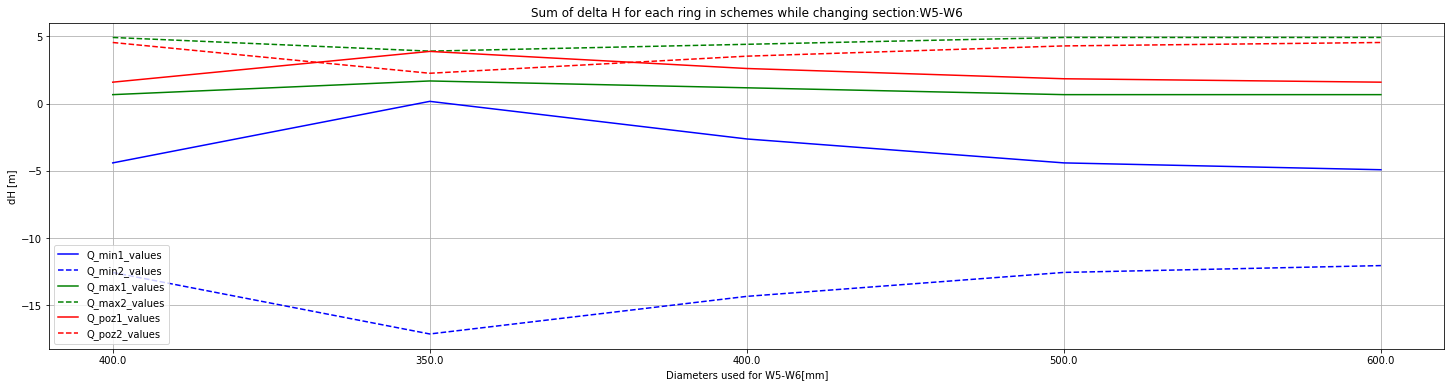

In [689]:
diameters_used = np.append([curr_section.srednica[0]], common_diameters)

x_values = np.arange(-1, len(common_diameters),1)
plt.figure(figsize=(25,6))
plt.title('Sum of delta H for each ring in schemes while changing section:' + section_name)
plt.grid()
plt.plot(x_values, Q_min1_values, label = 'Q_min1_values', color='blue',  linestyle='-')
plt.plot(x_values, Q_min2_values, label = 'Q_min2_values', color='blue',  linestyle='--')
plt.plot(x_values, Q_max1_values, label = 'Q_max1_values', color='green', linestyle='-')
plt.plot(x_values, Q_max2_values, label = 'Q_max2_values', color='green', linestyle='--')
plt.plot(x_values, Q_poz1_values, label = 'Q_poz1_values', color='red',   linestyle='-')
plt.plot(x_values, Q_poz2_values, label = 'Q_poz2_values', color='red',   linestyle='--')

plt.xticks(x_values, diameters_used)
plt.xlabel('Diameters used for ' + section_name + '[mm]')
plt.ylabel('dH [m]')
plt.legend()

In [690]:
############################ OLD ########################
Q_min2_values

array([-12.5536, -17.1292, -14.333 , -12.5536, -12.0452])

In [81]:
# MAIN ALGORITHM
#adjacent_diameters = getAdjacentDiametersToSection(pipes, 'W3-W4') # Get already set diameters of adjacent pipes.
#available_diameters_for_section = fitDiametersToAdjacentPipes(tables_df, adjacent_diameters) # Gives available diameters to fit with "dymensja" requirement
#
#available_diameters_for_section

array([500., 600., 700., 800., 900.])

In [693]:
# Szukanie srednicy i spadku po tablicach
lookup_v_max_value = 3
diameter_threshold_sections = 2
lookup_Q_value = 280
Q_threshold_value = 25
available_diameters_for_section = [400, 500]

curr_DES = getDiameterEntriesForQ(tables_df, lookup_v_max_value, diameter_threshold_sections, lookup_Q_value, Q_threshold_value, available_diameters_for_section)
curr_DES.sort_values(by=['srednica','Q'])
curr_DES


,spadek,Q,v,srednica
452,15.0,258.0,2.06,400.0
453,15.5,262.0,2.09,400.0
454,16.0,267.0,2.12,400.0
455,16.5,271.0,2.16,400.0
457,5.5,282.0,1.44,500.0
191,4.8,263.0,1.34,500.0
458,6.0,294.0,1.50,500.0
456,5.0,269.0,1.37,500.0
190,4.6,258.0,1.31,500.0


In [344]:
# DIAMETER CHARACTERISTICS CHARTS

In [397]:
x = bladddd
# 12 roznych srednic
lookup_v_min_value = 0
lookup_v_max_value = 2
L_series = [500, 750, 1000, 1500]
diameters_series = getTableDiameters(tables_df)

fig = plt.figure(figsize=(120,30))
n = 1
for curr_diameter in diameters_series:
    curr_DE = tables_df[ tables_df.srednica == curr_diameter]
    curr_DE = curr_DE[ tables_df.v > lookup_v_min_value]
    curr_DE = curr_DE[ tables_df.v < lookup_v_max_value]
    curr_DE.sort_values(by=['Q', 'spadek'], inplace =True)
    
    ax = fig.add_subplot(3,4,n)
    for curr_L in L_series:
        dH = (curr_L * curr_DE.spadek)/1000
        ax.plot(curr_DE.Q, dH, label= 'L=' + str(curr_L) + ' [m]')
        ax.set_xticks(curr_DE.Q)

    ax.legend()
    ax.grid()
    
    ax.set_title( 'D=' + str(curr_diameter) + ' [mm]', fontsize=16)
#     ax.set_xticks([])
    #plt.xlabel("spadek [%o]")
    plt.xlabel("Q [l/s]")
    plt.ylabel("delta H [m]")
    
    n += 1

NameError: name 'bladddd' is not defined

In [394]:
class Section:
    def __init__(self, name, start_node, end_node, length, section_q_loss):
        self.name = name
        self.start_node = start_node
        self.end_node = end_node
        self.length = length
        self.section_q_loss = section_q_loss

class Node:
    def __init__(self, name, node_q_loss):
        self.adjacent_sections = []
        self.name = name
        self.node_q_loss = node_q_loss
        
    def add_section(self, _section):
        print('foo:' + self.name + ', ' + _section)
        self.adjacent_sections  = np.append(self.adjacent_sections, _section)

n2 = Node('W2', 50)
n2.add_section('section 1')
n2.add_section('section 2')
n2.adjacent_sections

foo:W2, section 1
foo:W2, section 2


array(['section 1', 'section 2'], dtype='<U32')